# Clustering Yelp Restaurants

**To be completed INDIVIDUALLY and due on Febrary 17 at 7pm.**

In this assignment, we will be working with the [Yelp dataset](https://www.yelp.com/dataset/challenge). Download the data from Round 11. You can find the format of the dataset [here](https://www.yelp.com/dataset/documentation/json).

a) From the Business Objects, let's try to find culinary districts in **Las Vegas**. These are characterized by closeness and similarity of restaurants. Use the "longitude" and "latitude" to cluster closeness. Use "categories" to cluster for similarity. You are going to use the following popular categories: 'Mexican', 'Fast Food', 'Pizza', 'American (Traditional)', 'Sandwitches', 'Breakfast & Brunch', 'Chinese', 'Italian'.

Note that the spatial coordinates and restaurant categories have different units of scale. Your results could be arbitrarily skewed if you don't incorporate some scaling. For this purpose, you need to scale the latitude and longitude at a range from [1,5].

Find clusters using the 3 different techniques we discussed in class: k-means++, hierarchical, and GMM. **(3 pts)**

In [1]:
import json
import pandas as pd
import numpy as np
import copy
from sklearn import preprocessing
from sklearn.cluster import KMeans,AgglomerativeClustering
import sklearn.metrics as metrics
import scipy.cluster
import scipy.cluster.hierarchy as hierarchy
from sklearn import mixture
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import heapq

In [2]:
'''Preprpcess the dataset that make longitube, latitude and categories in one set'''
dataset = []
with open('business.json') as json_data:
    for t in json_data:
        data=json.loads(t)
        if data['city']=='Las Vegas':
            if any(i in data['categories'] for i in ('Mexican', 'Fast Food', 'Pizza', 'American (Traditional)', 'Sandwiches', 'Breakfast & Brunch', 'Chinese', 'Italian')):
                dataset.append(data)
#pd.DataFrame(dataset)
df = pd.DataFrame(dataset)
data = pd.DataFrame(df,columns = ['longitude', 'latitude','categories'])
pd.DataFrame(df,columns = ['longitude', 'latitude','categories'])

,longitude,latitude,categories
0,-115.118954,36.064652,"[Fast Food, Restaurants, Sandwiches]"
1,-115.241688,36.111057,"[Italian, Restaurants]"
2,-115.109310,36.130013,"[Restaurants, Fast Food, Burgers]"
3,-115.062353,36.112895,"[Sandwiches, Restaurants, Fast Food]"
4,-115.171409,36.034244,"[Restaurants, American (Traditional)]"
5,-115.118656,36.010086,"[Seafood, Italian, Pizza, Restaurants]"
6,-115.136079,36.098632,"[Karaoke, Bars, Mexican, Restaurants, Nightlif..."
7,-115.263279,36.271838,"[Dance Clubs, Nightlife, Restaurants, Barbeque..."
8,-115.142887,36.140925,"[Restaurants, American (Traditional), Food, Co..."
9,-115.210341,36.238059,"[Restaurants, Pizza]"


In [3]:
'''Mark 1 if restaurants have the category; while mark 0 if restaurants have the category.'''
feature_vector = []
for row in data.itertuples():
    location = list(row)[1:3]
    feature = [0, 0, 0, 0, 0, 0, 0, 0]
    if 'Mexican' in row.categories:
        feature[0] = 1
    if 'Fast Food' in row.categories:
        feature[1] = 1
    if 'Pizza' in row.categories:
        feature[2] = 1
    if 'American(Traditional)' in row.categories:
        feature[3] = 1
    if 'Sandwiches' in row.categories:
        feature[4] = 1
    if 'Breakfast & Brunch' in row.categories:
        feature[5] = 1
    if 'Chinese' in row.categories:
        feature[6] = 1
    if 'Italian' in row.categories:
        feature[7] = 1
    feature_vector.append(location + feature)
#print(location)
#X = np.asarray(feature_vector)
#print(X)

In [4]:
def scaling(X):
    Y = [[row[0]*5, row[1]*5, row[2], row[3], row[4], row[5], row[6], row[7], row[8], row[9]] for row in X]
    Y = np.asarray(Y)
    return Y
Y = scaling(feature_vector)
print(Y)

[[-575.5947705   180.3232615     0.         ...,    0.            0.            0.        ]
 [-576.2084405   180.555286      0.         ...,    0.            0.            1.        ]
 [-575.54655     180.650064      0.         ...,    0.            0.            0.        ]
 ..., 
 [-575.95628088  180.20313808    0.         ...,    0.            0.            0.        ]
 [-576.3219625   181.3550285     1.         ...,    1.            0.            0.        ]
 [-576.48387354  180.47539919    0.         ...,    1.            0.            0.        ]]


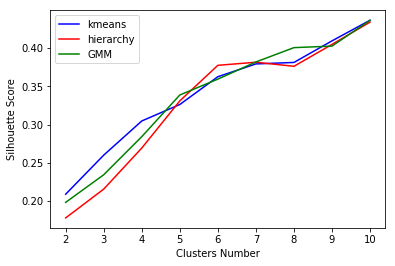

In [5]:
def cluster(maxi,data):
    km = np.zeros(maxi+1)
    h = np.zeros(maxi+1)
    g= np.zeros(maxi+1)
    for k in range(2,maxi+1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10).fit(data)
        km[k] = metrics.silhouette_score(data,kmeans.labels_,metric='euclidean')
        
        hierachy = AgglomerativeClustering(n_clusters=k).fit(data)
        h[k] = metrics.silhouette_score(data,hierachy.labels_,metric='euclidean')
        
        gmm = mixture.GaussianMixture(n_components=k, covariance_type='full').fit(data)
        gmm_labels = gmm.predict(data)
        g[k] = metrics.silhouette_score(data,gmm_labels,metric='euclidean')
        
    plt.plot(range(2,len(km)),km[2:],'b',label='kmeans')
    plt.plot(range(2,len(h)),h[2:],'r',label='hierarchy')
    plt.plot(range(2,len(g)),g[2:],'g',label='GMM')
    plt.xlabel('Clusters Number')
    plt.ylabel('Silhouette Score')
    plt.legend(loc ='best')
    plt.show()
cluster(10,Y)

b) Explain your data representation and how you determined certain parameters (for example, the number of clusters for each method). **(1 pt)**

As we can see, basically speaking,the Silhouette Scores of three methods have a increasing trend. However, the local maximum happens when cluster number is 8,so I think 8 is the appropriate number of cluster.

c) Visualize the clusters by plotting the longitude/latitude of the restaurants in a scatter plot. Label each cluster with a category. In a markdown, explain how labels are assigned. **(2 pts)**

Note that some categories are inherently more common (e.g. "pizza"). When labeling your clusters, you want to avoid the scenario where all clusters are labeled as "pizza" simply because of the uniformly large number of these restaurants across all clusters. In other words, we don’t want to point out that pizza restaurants are pretty much evenly distributed in high quantities everywhere, but rather discover when they, or another type of restaurant, appear in notably high quantities.

d) Now let's detect outliers. These are the points that are the farthest from the centroids of their clusters. In order to find the outliers, you need to find the distances of all cluster points from the centroid and select the ones whose distance is above the 85th percentile. **(3 pts)**

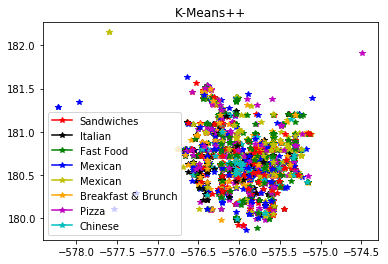

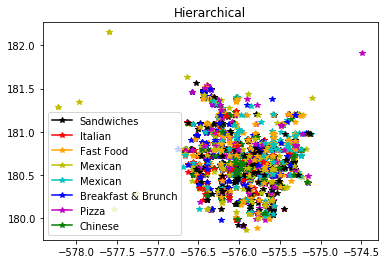

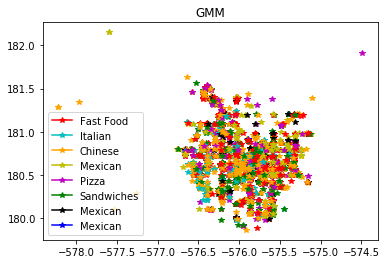

In [16]:
def clustercenter(result_list, cluster_labels):
    centroids_dict = dict()
    for i in range(len(cluster_labels)):
        if cluster_labels[i] in centroids_dict:
            centroids_dict[cluster_labels[i]] = [list(map(lambda x: x[0] + x[1],
                                                          zip(centroids_dict[cluster_labels[i]][0], result_list[i]))),
                                                 centroids_dict[cluster_labels[i]][1] + 1]
        else:
            centroids_dict[cluster_labels[i]] = [result_list[i], 1]
    for item in centroids_dict:
        centroids_dict[item][0] = [x / centroids_dict[item][1] for x in centroids_dict[item][0]]
    return centroids_dict


def label(result_list, cluster_labels):
    popular_categories = ['Mexican', 'Fast Food', 'Pizza',
                          'American (Traditional)', 'Sandwiches',
                          'Breakfast & Brunch', 'Chinese', 'Italian']
    label_category = dict()
    centroids = clustercenter(result_list, cluster_labels)
    for item in centroids:
        mass_index = centroids[item][0][2:].index(max(centroids[item][0][2:]))
        category = popular_categories[mass_index]
        label_category[item] = category
    return label_category

def find_outliers(result_list, cluster_labels):
    centroids_dict = clustercenter(result_list, cluster_labels)
    outlier_list = list()
    edge_dict = dict()
    dist_list = list()
    for i in range(len(cluster_labels)):
        vec_1 = np.array(result_list[i])
        vec_2 = np.array(centroids_dict[cluster_labels[i]][0])
        dist = np.linalg.norm(vec_1 - vec_2)
        dist_list.append(dist)
        if cluster_labels[i] in edge_dict:
            edge_dict[cluster_labels[i]].append(dist)
        else:
            edge_dict[cluster_labels[i]] = [dist]
    for item in edge_dict:
        edge = min(heapq.nlargest(int(len(edge_dict[item]) * 0.05), edge_dict[item]))
        edge_dict[item] = edge
    for i in range(len(cluster_labels)):
        if dist_list[i] > edge_dict[cluster_labels[i]]:
            outlier_list.append(1)
        else:
            outlier_list.append(0)
    return outlier_list


def clusters(result_list, method, outlier=None):
    cluster_labels = list()
    if method == 'kmeans':
        kmeans = KMeans(n_clusters=8).fit(result_list)
        cluster_labels = kmeans.labels_
        plt.title('K-Means++')
    elif method == 'hiera':
        agg = AgglomerativeClustering(n_clusters=8).fit(result_list)
        cluster_labels = agg.labels_
        plt.title('Hierarchical')
    elif method == 'gmm':
        gmm = GaussianMixture(n_components=8).fit(result_list)
        cluster_labels = gmm.predict(result_list)
        plt.title('GMM')
    label_dict = label(result_list, cluster_labels)
    mark = ['*', 'x']
    color = ['k', 'orange', 'r', 'y', 'g', 'c', 'b', 'm']
    tmp_list = list()
    for i in range(len(result_list)):
        mark_index = int(cluster_labels[i])
        if mark_index in tmp_list:
            plt.plot(result_list[i][0], result_list[i][1], color=color[mark_index], marker=mark[0])
        else:
            plt.plot(result_list[i][0], result_list[i][1], color=color[mark_index], marker=mark[0], label=label_dict[mark_index])
            tmp_list.append(mark_index)
    if outlier:
        outlier = find_outliers(result_list, cluster_labels)
        for i in range(len(outlier)):
            if outlier[i] == 1:
                mark_index = int(cluster_labels[i])
                plt.plot(result_list[i][0], result_list[i][1], color=color[mark_index], marker=mark[1])
    plt.legend(loc='best')
    plt.show()
    return None


clusters(Y, 'kmeans')
clusters(Y, 'hiera')
clusters(Y, 'gmm')

e) Give an analysis comparing the results you obtained from the 3 techniques. **(1 pts)**

k-means clustering is a method of vector quantization.k-means clustering aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean, serving as a prototype of the cluster. This results in a partitioning of the data space into Voronoi cells.
In data mining and statistics, hierarchical clustering (also called hierarchical cluster analysis or HCA) is a method of cluster analysis which seeks to build a hierarchy of clusters. 
A mixture model with high likelihood tends to have the following traits:component distributions have high “peaks” (data in one cluster are tight);the mixture model “covers” the data well (dominant patterns in the data are captured by component distributions).
Advantages of K-Means:1. Running Time is fast 2. Better for high dimensional data. 3. Easy to interpret and Implement.
Advantages of Guassian Mixture: Does not assume clusters to be of any geometry. Works well with non-linear geometric distributions as well.

----------